<a href="https://colab.research.google.com/github/Dichik/B-tree/blob/master/DeviceDeduplicationAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/building-2-whitelisted-sept122023.csv')
df.head()

,device_id,building_id,floor_id,room_id,room_desc,room_area,room_people_capacity,date_time_start_local,date_time_end_local,date_partition
0,bcd9079f526507a88c7ba5ff27be1e01735ccf1e,1,4,59,Training Room,NaN,16.0,2022-11-29T09:00:00.000Z,2022-11-29T09:03:00.000Z,20221129
1,bcd9079f526507a88c7ba5ff27be1e01735ccf1e,1,4,-1,Outside Trackable Area,NaN,NaN,2022-11-29T09:03:00.000Z,2022-11-29T09:08:00.000Z,20221129
2,bcd9079f526507a88c7ba5ff27be1e01735ccf1e,1,4,54,Booth,NaN,4.0,2022-11-29T09:08:00.000Z,2022-11-29T09:09:00.000Z,20221129
3,bcd9079f526507a88c7ba5ff27be1e01735ccf1e,1,4,-1,Outside Trackable Area,NaN,NaN,2022-11-29T09:09:00.000Z,2022-11-29T09:23:00.000Z,20221129
4,bcd9079f526507a88c7ba5ff27be1e01735ccf1e,1,4,-1,Outside Trackable Area,NaN,NaN,2022-11-29T09:25:00.000Z,2022-11-29T09:25:00.000Z,20221129


In [ ]:
df.describe()

,building_id,floor_id,room_id,room_area,room_people_capacity,date_partition
count,340043.0,340043.000000,340043.000000,0.0,144631.000000,3.400430e+05
mean,1.0,6.207236,64.868631,NaN,20.332405,2.022112e+07
std,0.0,3.140527,99.212946,NaN,24.629757,6.137411e+00
min,1.0,1.000000,-1.000000,NaN,-1.000000,2.022112e+07
25%,1.0,4.000000,-1.000000,NaN,6.000000,2.022112e+07
50%,1.0,6.000000,-1.000000,NaN,16.000000,2.022112e+07
75%,1.0,9.000000,110.000000,NaN,28.000000,2.022113e+07
max,1.0,11.000000,314.000000,NaN,186.000000,2.022113e+07


### Number of unique rooms

In [ ]:
df['room_id'].nunique()

316

In [ ]:
rooms_df = df[['device_id', 'room_id']].groupby(['room_id']).count()
rooms_df.reset_index(inplace=True)
rooms_df.head()

,room_id,device_id
0,-1,195412
1,0,1146
2,1,939
3,2,60
4,3,20


In [ ]:
rooms_df.columns

Index(['room_id', 'device_id'], dtype='object')

In [ ]:
count_no_rooms = rooms_df.iloc[0]
count_no_rooms

room_id          -1
device_id    195412
Name: 0, dtype: int64

In [ ]:
count_rooms = rooms_df['device_id'].sum() - count_no_rooms
count_rooms

room_id      340044
device_id    144631
Name: 0, dtype: int64

- lots of devices where out of room (room_id = -1)

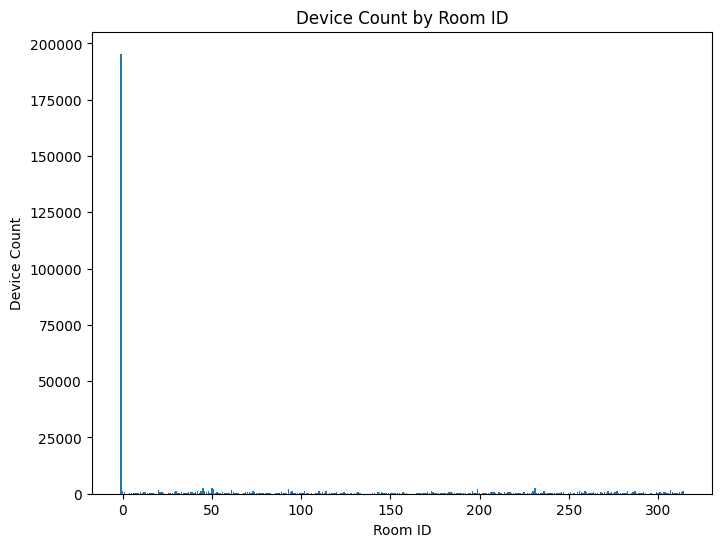

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(rooms_df['room_id'], rooms_df['device_id'])
plt.xlabel('Room ID')
plt.ylabel('Device Count')
plt.title('Device Count by Room ID')
plt.show()

In [ ]:
df['date_time_start_local'] = pd.to_datetime(df['date_time_start_local'])
df['date_time_end_local'] = pd.to_datetime(df['date_time_end_local'])

In [ ]:
df['start_time'] = df['date_time_start_local'].dt.hour + df['date_time_start_local'].dt.minute / 60
df['start_date'] = df['date_time_start_local'].dt.date
df['start_day_of_week'] = df['date_time_start_local'].dt.day_name()
df['start_month'] = df['date_time_start_local'].dt.strftime('%B')

In [ ]:
df['end_time'] = df['date_time_end_local'].dt.hour + df['date_time_end_local'].dt.minute / 60
df['end_date'] = df['date_time_end_local'].dt.date
df['end_day_of_week'] = df['date_time_end_local'].dt.day_name()
df['end_month'] = df['date_time_end_local'].dt.strftime('%B')

In [ ]:
df['delta_time'] = (
    pd.to_datetime(df['end_time']) -
    pd.to_datetime(df['start_time'])
  ).dt.total_seconds() / 60

In [ ]:
# FIXME it doesn't work as it supposed to work

summary_stats = df['delta_time'].describe()

formatted_stats = summary_stats.map('{:.6f}'.format)
formatted_stats.index = ['Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max']

print(formatted_stats)

Count      340043.000000
Mean            0.000000
Std Dev         0.000000
Min            -0.000000
25%             0.000000
Median          0.000000
75%             0.000000
Max             0.000000
Name: delta_time, dtype: object


In [ ]:
devices_df = df[['device_id', 'room_id']].groupby(by=['device_id']).count()

devices_df.reset_index(inplace=True)
devices_df.rename(columns={'room_id': 'nrooms'}, inplace=True)

devices_df.head()

,device_id,nrooms
0,0032646e0be5d7c7e0474fa334b4b4762986c849,491
1,0050b33237c05889ca09ddb558d180a215ce8cc3,638
2,0058d99698256f39a88c8ae46ad2d29b9adddfb7,104
3,006c1c2cb875207ed69bea3ee90ddb7b0111887d,94
4,0131e4b9e51f14030ccb09bddee21744b1543c4d,655


- we have only 5 unique devices here

In [ ]:
# в якій кімнаті максимальна к-сть девайсів і різні відношення

In [ ]:
# threshold коли в нас девайс швидко покидає кімнату (як визначати телефон)

In [ ]:
# проаналізувати і детектити девайси

In [ ]:
# проаналізувати outside track area область

In [ ]:
# спробувати задетектити чи девайс телефон (часто носять його)

In [ ]:
# чи можемо ми розділити девайси на рухомі і нерухомі

In [ ]:
# sort table by time

In [ ]:
# Notes:
# - don't worget about pickle
# - show charts